In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Data preprocessing
train_dir = "/kaggle/input/augmented-hardhat-vest-dataset/DIV2K_train_HR/"  # Replace with your actual path
output_dir = './'
os.makedirs('hr_images/', exist_ok=True)
os.makedirs('lr_images/', exist_ok=True)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

for img in os.listdir(train_dir):
    if is_image_file(img):
        img_array = cv2.imread(train_dir + img)
        img_array = cv2.resize(img_array, (128, 128))
        lr_img_array = cv2.resize(img_array, (32, 32))
        cv2.imwrite(output_dir + "hr_images/" + img, img_array)
        cv2.imwrite(output_dir + "lr_images/" + img, lr_img_array)

lr_list = os.listdir("./lr_images")
hr_list = os.listdir("./hr_images")

lr_images = []
hr_images = []
for lr_img, hr_img in zip(lr_list, hr_list):
    img_lr = cv2.imread("./lr_images/" + lr_img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_hr = cv2.imread("./hr_images/" + hr_img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

lr_train = torch.from_numpy(lr_train).permute(0, 3, 1, 2).float()
hr_train = torch.from_numpy(hr_train).permute(0, 3, 1, 2).float()
lr_test = torch.from_numpy(lr_test).permute(0, 3, 1, 2).float()
hr_test = torch.from_numpy(hr_test).permute(0, 3, 1, 2).float()


# PyTorch Model Definitions

class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out


class UpscaleBlock(nn.Module):
    def __init__(self):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.prelu = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)
        return out


class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()
        self.res_blocks = nn.Sequential(*[ResBlock() for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.upscale1 = UpscaleBlock()
        self.upscale2 = UpscaleBlock()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.prelu(out1)
        out = self.res_blocks(out1)
        out = self.conv2(out)
        out = self.bn(out)
        out += out1
        out = self.upscale1(out)
        out = self.upscale2(out)
        out = self.conv3(out)
        return out



class DiscriminatorBlock(nn.Module):
    def __init__(self, in_filters, out_filters, strides=1, bn=True):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=strides, padding=1)
        self.bn = nn.BatchNorm2d(out_filters) if bn else None  # Use nn.BatchNorm2d directly
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.conv(x)
        if self.bn:
            out = self.bn(out)
        out = self.lrelu(out)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block1 = DiscriminatorBlock(3, 64, bn=False)
        self.block2 = DiscriminatorBlock(64, 64, strides=2)
        self.block3 = DiscriminatorBlock(64, 128)
        self.block4 = DiscriminatorBlock(128, 128, strides=2)
        self.block5 = DiscriminatorBlock(128, 256)
        self.block6 = DiscriminatorBlock(256, 256, strides=2)
        self.block7 = DiscriminatorBlock(256, 512)
        self.block8 = DiscriminatorBlock(512, 512, strides=2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(512 * 6 * 6, 1024)
        self.lrelu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(1024, 1)


    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out)
        out = self.adaptive_pool(out)
        out = self.flatten(out)

        out = self.linear1(out)
        out = self.lrelu(out)
        out = self.linear2(out)


        return out



class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg_weights_path):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19()
        if vgg_weights_path:
            state_dict = torch.load(vgg_weights_path)
            vgg19.load_state_dict(state_dict, strict=False)  # Handle potential key mismatches


        self.features = nn.Sequential(*list(vgg19.features.children())[:11]) #Up to 10th layer for content loss
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        return self.features(x)


# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)


vgg_weights_path = '/kaggle/input/vgg19-weights-pth/vgg19-dcbb9e9d.pth' # Replace with your path
vgg = VGGFeatureExtractor(vgg_weights_path).to(device)


criterion_gan = nn.BCEWithLogitsLoss()  # Includes Sigmoid
criterion_content = nn.MSELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

batch_size = 8 # Adjust based on your GPU memory
epochs = 1000

for epoch in range(epochs):
    g_losses = []
    d_losses = []
    for i in tqdm(range(0, len(lr_train), batch_size)):
        lr_batch = lr_train[i:i + batch_size].to(device)
        hr_batch = hr_train[i:i + batch_size].to(device)

        # Discriminator training
        optimizer_d.zero_grad()
        fake_images = generator(lr_batch)
        real_labels = torch.ones(lr_batch.size(0), 1).to(device) # Size should match batch size
        fake_labels = torch.zeros(lr_batch.size(0), 1).to(device)

        d_loss_real = criterion_gan(discriminator(hr_batch), real_labels)
        d_loss_fake = criterion_gan(discriminator(fake_images.detach()), fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_d.step()

        # Generator training
        optimizer_g.zero_grad()
        g_loss_gan = criterion_gan(discriminator(fake_images), real_labels)
        vgg_features_real = vgg(hr_batch)
        vgg_features_fake = vgg(fake_images)
        g_loss_content = criterion_content(vgg_features_fake, vgg_features_real)
        g_loss = 0.001 * g_loss_gan + g_loss_content
        g_loss.backward()
        optimizer_g.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, G Loss: {np.mean(g_losses):.4f}, D Loss: {np.mean(d_losses):.4f}")
torch.save(generator.state_dict(), "final_generator.pt")


# ... (Testing code -  add your testing code here if needed) ...

/tmp/ipykernel_23/2809372175.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(vgg_weights_path)
100%|██████████| 67/67 [00:11<00:00,  5.86it/s]


Epoch 1/1000, G Loss: 11.9369, D Loss: 0.0320


100%|██████████| 67/67 [00:09<00:00,  6.81it/s]


Epoch 2/1000, G Loss: 9.6242, D Loss: 0.0001


100%|██████████| 67/67 [00:09<00:00,  6.78it/s]


Epoch 3/1000, G Loss: 8.9208, D Loss: 0.0571


100%|██████████| 67/67 [00:09<00:00,  6.74it/s]


Epoch 4/1000, G Loss: 8.5178, D Loss: 0.0007


100%|██████████| 67/67 [00:10<00:00,  6.68it/s]


Epoch 5/1000, G Loss: 8.2412, D Loss: 0.0199


100%|██████████| 67/67 [00:10<00:00,  6.65it/s]


Epoch 6/1000, G Loss: 8.0386, D Loss: 0.0208


100%|██████████| 67/67 [00:10<00:00,  6.52it/s]


Epoch 7/1000, G Loss: 7.8628, D Loss: 0.2373


100%|██████████| 67/67 [00:10<00:00,  6.47it/s]


Epoch 8/1000, G Loss: 7.7272, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.40it/s]


Epoch 9/1000, G Loss: 7.6134, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 10/1000, G Loss: 7.5129, D Loss: 0.0002


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 11/1000, G Loss: 7.4228, D Loss: 0.0002


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 12/1000, G Loss: 7.3403, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.18it/s]


Epoch 13/1000, G Loss: 7.2635, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.17it/s]


Epoch 14/1000, G Loss: 7.1940, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.22it/s]


Epoch 15/1000, G Loss: 7.1270, D Loss: 0.0006


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 16/1000, G Loss: 7.0653, D Loss: 0.0017


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 17/1000, G Loss: 7.0069, D Loss: 0.0066


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 18/1000, G Loss: 6.9479, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 19/1000, G Loss: 6.8925, D Loss: 0.0034


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 20/1000, G Loss: 6.8369, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 21/1000, G Loss: 6.7773, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 22/1000, G Loss: 6.7188, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 23/1000, G Loss: 6.6587, D Loss: 0.0640


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 24/1000, G Loss: 6.6112, D Loss: 0.0005


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 25/1000, G Loss: 6.5589, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 26/1000, G Loss: 6.5095, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 27/1000, G Loss: 6.4609, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 28/1000, G Loss: 6.4103, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 29/1000, G Loss: 6.3563, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 30/1000, G Loss: 6.3084, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 31/1000, G Loss: 6.2630, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 32/1000, G Loss: 6.2251, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 33/1000, G Loss: 6.1709, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 34/1000, G Loss: 6.1181, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 35/1000, G Loss: 6.0675, D Loss: 0.0002


100%|██████████| 67/67 [00:10<00:00,  6.24it/s]


Epoch 36/1000, G Loss: 6.0208, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 37/1000, G Loss: 5.9859, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 38/1000, G Loss: 5.9546, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 39/1000, G Loss: 5.9200, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 40/1000, G Loss: 5.8809, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 41/1000, G Loss: 5.8342, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 42/1000, G Loss: 5.8054, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 43/1000, G Loss: 5.7889, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 44/1000, G Loss: 5.7733, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 45/1000, G Loss: 5.7437, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 46/1000, G Loss: 5.7102, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 47/1000, G Loss: 5.6676, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 48/1000, G Loss: 5.5946, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 49/1000, G Loss: 5.5248, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 50/1000, G Loss: 5.4721, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 51/1000, G Loss: 5.4283, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 52/1000, G Loss: 5.4025, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 53/1000, G Loss: 5.3831, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 54/1000, G Loss: 5.3657, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 55/1000, G Loss: 5.3430, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 56/1000, G Loss: 5.3072, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 57/1000, G Loss: 5.2679, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 58/1000, G Loss: 5.2196, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 59/1000, G Loss: 5.1896, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 60/1000, G Loss: 5.1771, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 61/1000, G Loss: 5.1478, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 62/1000, G Loss: 5.1291, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 63/1000, G Loss: 5.1076, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 64/1000, G Loss: 5.0800, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 65/1000, G Loss: 5.0502, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 66/1000, G Loss: 5.0121, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 67/1000, G Loss: 4.9775, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 68/1000, G Loss: 4.9475, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 69/1000, G Loss: 4.9150, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 70/1000, G Loss: 4.8900, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 71/1000, G Loss: 4.8669, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 72/1000, G Loss: 4.8373, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 73/1000, G Loss: 4.8033, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 74/1000, G Loss: 4.7795, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 75/1000, G Loss: 4.7411, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 76/1000, G Loss: 4.7033, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 77/1000, G Loss: 4.6695, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 78/1000, G Loss: 4.6425, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 79/1000, G Loss: 4.6278, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 80/1000, G Loss: 4.6143, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 81/1000, G Loss: 4.6060, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 82/1000, G Loss: 4.5821, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 83/1000, G Loss: 4.5515, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 84/1000, G Loss: 4.5344, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 85/1000, G Loss: 4.5039, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 86/1000, G Loss: 4.4615, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 87/1000, G Loss: 4.4242, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 88/1000, G Loss: 4.4047, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 89/1000, G Loss: 4.3817, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 90/1000, G Loss: 4.3564, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 91/1000, G Loss: 4.3323, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 92/1000, G Loss: 4.3087, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 93/1000, G Loss: 4.2813, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 94/1000, G Loss: 4.2319, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 95/1000, G Loss: 4.1924, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 96/1000, G Loss: 4.1596, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 97/1000, G Loss: 4.1244, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 98/1000, G Loss: 4.0988, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 99/1000, G Loss: 4.0847, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 100/1000, G Loss: 4.0647, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 101/1000, G Loss: 4.0501, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 102/1000, G Loss: 4.0437, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 103/1000, G Loss: 4.0392, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 104/1000, G Loss: 4.0317, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 105/1000, G Loss: 4.0201, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 106/1000, G Loss: 3.9987, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 107/1000, G Loss: 3.9796, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 108/1000, G Loss: 3.9705, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 109/1000, G Loss: 3.9543, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 110/1000, G Loss: 3.9301, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 111/1000, G Loss: 3.9086, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 112/1000, G Loss: 3.8943, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 113/1000, G Loss: 3.9051, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 114/1000, G Loss: 3.9132, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 115/1000, G Loss: 3.8933, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 116/1000, G Loss: 3.8655, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 117/1000, G Loss: 3.8433, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 118/1000, G Loss: 3.8198, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 119/1000, G Loss: 3.8024, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 120/1000, G Loss: 3.8038, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 121/1000, G Loss: 3.7950, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 122/1000, G Loss: 3.7771, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 123/1000, G Loss: 3.7706, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 124/1000, G Loss: 3.7562, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 125/1000, G Loss: 3.7335, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 126/1000, G Loss: 3.7070, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 127/1000, G Loss: 3.6941, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 128/1000, G Loss: 3.7009, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 129/1000, G Loss: 3.6929, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 130/1000, G Loss: 3.6775, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 131/1000, G Loss: 3.6604, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 132/1000, G Loss: 3.6485, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 133/1000, G Loss: 3.6483, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 134/1000, G Loss: 3.6453, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 135/1000, G Loss: 3.6348, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 136/1000, G Loss: 3.6188, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 137/1000, G Loss: 3.5956, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 138/1000, G Loss: 3.5770, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 139/1000, G Loss: 3.5620, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 140/1000, G Loss: 3.5501, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 141/1000, G Loss: 3.5448, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 142/1000, G Loss: 3.5409, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 143/1000, G Loss: 3.5162, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 144/1000, G Loss: 3.4915, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 145/1000, G Loss: 3.4835, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 146/1000, G Loss: 3.4673, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 147/1000, G Loss: 3.4561, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 148/1000, G Loss: 3.4501, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 149/1000, G Loss: 3.4441, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 150/1000, G Loss: 3.4390, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 151/1000, G Loss: 3.4600, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 152/1000, G Loss: 3.4757, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 153/1000, G Loss: 3.4767, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 154/1000, G Loss: 3.4695, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 155/1000, G Loss: 3.4603, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 156/1000, G Loss: 3.4454, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 157/1000, G Loss: 3.4174, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 158/1000, G Loss: 3.3871, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 159/1000, G Loss: 3.3728, D Loss: 0.0784


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 160/1000, G Loss: 3.3767, D Loss: 0.0113


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 161/1000, G Loss: 3.3729, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 162/1000, G Loss: 3.3584, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 163/1000, G Loss: 3.3429, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 164/1000, G Loss: 3.3388, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 165/1000, G Loss: 3.3159, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 166/1000, G Loss: 3.2961, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 167/1000, G Loss: 3.2780, D Loss: 0.0024


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 168/1000, G Loss: 3.2497, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 169/1000, G Loss: 3.2250, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 170/1000, G Loss: 3.2036, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 171/1000, G Loss: 3.2007, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 172/1000, G Loss: 3.1980, D Loss: 0.0218


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 173/1000, G Loss: 3.1924, D Loss: 0.0676


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 174/1000, G Loss: 3.1797, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 175/1000, G Loss: 3.1822, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 176/1000, G Loss: 3.1746, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 177/1000, G Loss: 3.1668, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 178/1000, G Loss: 3.1526, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 179/1000, G Loss: 3.1542, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 180/1000, G Loss: 3.1543, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 181/1000, G Loss: 3.1474, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 182/1000, G Loss: 3.1413, D Loss: 0.0002


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 183/1000, G Loss: 3.1398, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 184/1000, G Loss: 3.1388, D Loss: 0.0007


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 185/1000, G Loss: 3.1395, D Loss: 0.0025


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 186/1000, G Loss: 3.1318, D Loss: 0.0005


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 187/1000, G Loss: 3.1225, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 188/1000, G Loss: 3.1132, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 189/1000, G Loss: 3.0924, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 190/1000, G Loss: 3.0820, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 191/1000, G Loss: 3.0808, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 192/1000, G Loss: 3.0681, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 193/1000, G Loss: 3.0544, D Loss: 0.0062


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 194/1000, G Loss: 3.0573, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 195/1000, G Loss: 3.0476, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 196/1000, G Loss: 3.0278, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 197/1000, G Loss: 3.0216, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 198/1000, G Loss: 3.0160, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 199/1000, G Loss: 2.9943, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 200/1000, G Loss: 2.9741, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 201/1000, G Loss: 2.9589, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 202/1000, G Loss: 2.9608, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 203/1000, G Loss: 2.9752, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 204/1000, G Loss: 2.9883, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 205/1000, G Loss: 2.9896, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 206/1000, G Loss: 2.9601, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 207/1000, G Loss: 2.9399, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 208/1000, G Loss: 2.9363, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 209/1000, G Loss: 2.9483, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 210/1000, G Loss: 2.9553, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 211/1000, G Loss: 2.9696, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 212/1000, G Loss: 2.9782, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 213/1000, G Loss: 2.9838, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 214/1000, G Loss: 2.9702, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 215/1000, G Loss: 2.9452, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 216/1000, G Loss: 2.9245, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 217/1000, G Loss: 2.9097, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 218/1000, G Loss: 2.9010, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 219/1000, G Loss: 2.9011, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 220/1000, G Loss: 2.9193, D Loss: 0.0082


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 221/1000, G Loss: 2.9433, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 222/1000, G Loss: 2.9539, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 223/1000, G Loss: 2.9484, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 224/1000, G Loss: 2.9310, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 225/1000, G Loss: 2.9082, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 226/1000, G Loss: 2.8828, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 227/1000, G Loss: 2.8680, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 228/1000, G Loss: 2.8521, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 229/1000, G Loss: 2.8487, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 230/1000, G Loss: 2.8459, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 231/1000, G Loss: 2.8442, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 232/1000, G Loss: 2.8351, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 233/1000, G Loss: 2.8273, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 234/1000, G Loss: 2.8232, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 235/1000, G Loss: 2.8200, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 236/1000, G Loss: 2.8276, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 237/1000, G Loss: 2.8305, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 238/1000, G Loss: 2.8261, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 239/1000, G Loss: 2.8264, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 240/1000, G Loss: 2.8291, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 241/1000, G Loss: 2.8344, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 242/1000, G Loss: 2.8253, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 243/1000, G Loss: 2.8270, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 244/1000, G Loss: 2.8281, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 245/1000, G Loss: 2.8184, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 246/1000, G Loss: 2.8030, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 247/1000, G Loss: 2.7896, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 248/1000, G Loss: 2.7704, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 249/1000, G Loss: 2.7552, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 250/1000, G Loss: 2.7363, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 251/1000, G Loss: 2.7334, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 252/1000, G Loss: 2.7338, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 253/1000, G Loss: 2.7415, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 254/1000, G Loss: 2.7479, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 255/1000, G Loss: 2.7534, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 256/1000, G Loss: 2.7638, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 257/1000, G Loss: 2.7531, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 258/1000, G Loss: 2.7481, D Loss: 0.0374


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 259/1000, G Loss: 2.7376, D Loss: 0.0010


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 260/1000, G Loss: 2.7238, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 261/1000, G Loss: 2.7173, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 262/1000, G Loss: 2.7146, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 263/1000, G Loss: 2.6941, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 264/1000, G Loss: 2.6865, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 265/1000, G Loss: 2.6945, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 266/1000, G Loss: 2.7078, D Loss: 0.0008


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 267/1000, G Loss: 2.7270, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 268/1000, G Loss: 2.7255, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 269/1000, G Loss: 2.7236, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 270/1000, G Loss: 2.7332, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 271/1000, G Loss: 2.7266, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 272/1000, G Loss: 2.7198, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 273/1000, G Loss: 2.7265, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 274/1000, G Loss: 2.7222, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 275/1000, G Loss: 2.7233, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 276/1000, G Loss: 2.7285, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 277/1000, G Loss: 2.7180, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 278/1000, G Loss: 2.7109, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 279/1000, G Loss: 2.7028, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 280/1000, G Loss: 2.6942, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 281/1000, G Loss: 2.6825, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 282/1000, G Loss: 2.6708, D Loss: 0.0255


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 283/1000, G Loss: 2.6561, D Loss: 0.0007


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 284/1000, G Loss: 2.6481, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 285/1000, G Loss: 2.6345, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 286/1000, G Loss: 2.6267, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 287/1000, G Loss: 2.6295, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 288/1000, G Loss: 2.6388, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 289/1000, G Loss: 2.6515, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 290/1000, G Loss: 2.6552, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 291/1000, G Loss: 2.6479, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 292/1000, G Loss: 2.6211, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 293/1000, G Loss: 2.5929, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 294/1000, G Loss: 2.5794, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 295/1000, G Loss: 2.5789, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 296/1000, G Loss: 2.5787, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 297/1000, G Loss: 2.5727, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 298/1000, G Loss: 2.5673, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 299/1000, G Loss: 2.5689, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 300/1000, G Loss: 2.5653, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 301/1000, G Loss: 2.5652, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 302/1000, G Loss: 2.5713, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 303/1000, G Loss: 2.5711, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 304/1000, G Loss: 2.5583, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 305/1000, G Loss: 2.5499, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 306/1000, G Loss: 2.5494, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 307/1000, G Loss: 2.5440, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 308/1000, G Loss: 2.5385, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 309/1000, G Loss: 2.5363, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 310/1000, G Loss: 2.5438, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 311/1000, G Loss: 2.5278, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 312/1000, G Loss: 2.5086, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 313/1000, G Loss: 2.4856, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 314/1000, G Loss: 2.4622, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 315/1000, G Loss: 2.4453, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 316/1000, G Loss: 2.4484, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 317/1000, G Loss: 2.4695, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 318/1000, G Loss: 2.4828, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 319/1000, G Loss: 2.4915, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 320/1000, G Loss: 2.4937, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 321/1000, G Loss: 2.5130, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 322/1000, G Loss: 2.5215, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 323/1000, G Loss: 2.5204, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.37it/s]


Epoch 324/1000, G Loss: 2.5010, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 325/1000, G Loss: 2.4766, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 326/1000, G Loss: 2.4618, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 327/1000, G Loss: 2.4580, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 328/1000, G Loss: 2.4642, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 329/1000, G Loss: 2.4852, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 330/1000, G Loss: 2.4883, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 331/1000, G Loss: 2.4739, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 332/1000, G Loss: 2.4604, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 333/1000, G Loss: 2.4483, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 334/1000, G Loss: 2.4473, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 335/1000, G Loss: 2.4443, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 336/1000, G Loss: 2.4370, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 337/1000, G Loss: 2.4361, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 338/1000, G Loss: 2.4457, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 339/1000, G Loss: 2.4695, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 340/1000, G Loss: 2.4790, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 341/1000, G Loss: 2.4728, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 342/1000, G Loss: 2.4754, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 343/1000, G Loss: 2.4896, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 344/1000, G Loss: 2.4806, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 345/1000, G Loss: 2.4710, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 346/1000, G Loss: 2.4548, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 347/1000, G Loss: 2.4452, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 348/1000, G Loss: 2.4409, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 349/1000, G Loss: 2.4396, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 350/1000, G Loss: 2.4390, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 351/1000, G Loss: 2.4233, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 352/1000, G Loss: 2.4042, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 353/1000, G Loss: 2.3961, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 354/1000, G Loss: 2.4041, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 355/1000, G Loss: 2.4210, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 356/1000, G Loss: 2.4300, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 357/1000, G Loss: 2.4418, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 358/1000, G Loss: 2.4617, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 359/1000, G Loss: 2.4593, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 360/1000, G Loss: 2.4336, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 361/1000, G Loss: 2.4249, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 362/1000, G Loss: 2.4024, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 363/1000, G Loss: 2.3943, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 364/1000, G Loss: 2.3862, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 365/1000, G Loss: 2.3743, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 366/1000, G Loss: 2.3652, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 367/1000, G Loss: 2.3616, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 368/1000, G Loss: 2.3601, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 369/1000, G Loss: 2.3583, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 370/1000, G Loss: 2.3620, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 371/1000, G Loss: 2.3676, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 372/1000, G Loss: 2.3737, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 373/1000, G Loss: 2.3827, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 374/1000, G Loss: 2.3941, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 375/1000, G Loss: 2.3929, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 376/1000, G Loss: 2.3894, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 377/1000, G Loss: 2.3877, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 378/1000, G Loss: 2.3946, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 379/1000, G Loss: 2.4136, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 380/1000, G Loss: 2.4349, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 381/1000, G Loss: 2.4338, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 382/1000, G Loss: 2.4125, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 383/1000, G Loss: 2.3928, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 384/1000, G Loss: 2.3752, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 385/1000, G Loss: 2.3749, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 386/1000, G Loss: 2.3646, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 387/1000, G Loss: 2.3513, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 388/1000, G Loss: 2.3483, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 389/1000, G Loss: 2.3490, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 390/1000, G Loss: 2.3555, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 391/1000, G Loss: 2.3622, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 392/1000, G Loss: 2.3723, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 393/1000, G Loss: 2.3752, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 394/1000, G Loss: 2.3696, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 395/1000, G Loss: 2.3486, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 396/1000, G Loss: 2.3283, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 397/1000, G Loss: 2.3283, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 398/1000, G Loss: 2.3249, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 399/1000, G Loss: 2.3188, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 400/1000, G Loss: 2.3108, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 401/1000, G Loss: 2.3014, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 402/1000, G Loss: 2.2992, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 403/1000, G Loss: 2.2994, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 404/1000, G Loss: 2.2986, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 405/1000, G Loss: 2.2975, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 406/1000, G Loss: 2.2989, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 407/1000, G Loss: 2.2967, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 408/1000, G Loss: 2.3034, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 409/1000, G Loss: 2.3048, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 410/1000, G Loss: 2.2942, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 411/1000, G Loss: 2.2926, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 412/1000, G Loss: 2.2861, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 413/1000, G Loss: 2.2864, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 414/1000, G Loss: 2.2914, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 415/1000, G Loss: 2.2806, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 416/1000, G Loss: 2.2654, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 417/1000, G Loss: 2.2572, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 418/1000, G Loss: 2.2609, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 419/1000, G Loss: 2.2659, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 420/1000, G Loss: 2.2726, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 421/1000, G Loss: 2.2684, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 422/1000, G Loss: 2.2731, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 423/1000, G Loss: 2.2678, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 424/1000, G Loss: 2.2577, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 425/1000, G Loss: 2.2339, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 426/1000, G Loss: 2.2228, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 427/1000, G Loss: 2.2182, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 428/1000, G Loss: 2.2242, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 429/1000, G Loss: 2.2231, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 430/1000, G Loss: 2.2281, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 431/1000, G Loss: 2.2322, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 432/1000, G Loss: 2.2361, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 433/1000, G Loss: 2.2245, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 434/1000, G Loss: 2.2107, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 435/1000, G Loss: 2.2102, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 436/1000, G Loss: 2.2061, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 437/1000, G Loss: 2.2027, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 438/1000, G Loss: 2.2015, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 439/1000, G Loss: 2.1982, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 440/1000, G Loss: 2.1973, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 441/1000, G Loss: 2.1964, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 442/1000, G Loss: 2.2132, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 443/1000, G Loss: 2.2199, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 444/1000, G Loss: 2.2150, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 445/1000, G Loss: 2.2214, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 446/1000, G Loss: 2.2176, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 447/1000, G Loss: 2.1969, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 448/1000, G Loss: 2.1866, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 449/1000, G Loss: 2.1783, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 450/1000, G Loss: 2.1780, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 451/1000, G Loss: 2.1848, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 452/1000, G Loss: 2.1835, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 453/1000, G Loss: 2.1689, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 454/1000, G Loss: 2.1610, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 455/1000, G Loss: 2.1636, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 456/1000, G Loss: 2.1754, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 457/1000, G Loss: 2.1838, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 458/1000, G Loss: 2.1871, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 459/1000, G Loss: 2.1890, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 460/1000, G Loss: 2.1983, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 461/1000, G Loss: 2.1979, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 462/1000, G Loss: 2.1969, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 463/1000, G Loss: 2.1860, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 464/1000, G Loss: 2.1803, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 465/1000, G Loss: 2.1856, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 466/1000, G Loss: 2.1937, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 467/1000, G Loss: 2.1907, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 468/1000, G Loss: 2.1834, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 469/1000, G Loss: 2.1813, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 470/1000, G Loss: 2.1859, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 471/1000, G Loss: 2.1852, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 472/1000, G Loss: 2.1720, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 473/1000, G Loss: 2.1671, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 474/1000, G Loss: 2.1588, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 475/1000, G Loss: 2.1582, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 476/1000, G Loss: 2.1637, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 477/1000, G Loss: 2.1700, D Loss: 0.0998


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 478/1000, G Loss: 2.1465, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 479/1000, G Loss: 2.1543, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 480/1000, G Loss: 2.1544, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 481/1000, G Loss: 2.1478, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 482/1000, G Loss: 2.1458, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 483/1000, G Loss: 2.1405, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 484/1000, G Loss: 2.1412, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 485/1000, G Loss: 2.1358, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 486/1000, G Loss: 2.1291, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 487/1000, G Loss: 2.1263, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 488/1000, G Loss: 2.1273, D Loss: 0.0006


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 489/1000, G Loss: 2.1230, D Loss: 0.0141


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 490/1000, G Loss: 2.1147, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 491/1000, G Loss: 2.1024, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 492/1000, G Loss: 2.0937, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 493/1000, G Loss: 2.0926, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 494/1000, G Loss: 2.0925, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 495/1000, G Loss: 2.0866, D Loss: 0.0575


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 496/1000, G Loss: 2.0838, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 497/1000, G Loss: 2.0977, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 498/1000, G Loss: 2.1142, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 499/1000, G Loss: 2.1230, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 500/1000, G Loss: 2.1262, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 501/1000, G Loss: 2.1522, D Loss: 0.0019


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 502/1000, G Loss: 2.1762, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 503/1000, G Loss: 2.1776, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 504/1000, G Loss: 2.1757, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 505/1000, G Loss: 2.1648, D Loss: 0.0009


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 506/1000, G Loss: 2.1472, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 507/1000, G Loss: 2.1242, D Loss: 0.0285


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 508/1000, G Loss: 2.1204, D Loss: 0.0535


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 509/1000, G Loss: 2.0994, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 510/1000, G Loss: 2.0904, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 511/1000, G Loss: 2.0899, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 512/1000, G Loss: 2.0978, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 513/1000, G Loss: 2.1045, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 514/1000, G Loss: 2.1059, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 515/1000, G Loss: 2.1020, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 516/1000, G Loss: 2.0922, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 517/1000, G Loss: 2.0753, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 518/1000, G Loss: 2.0654, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 519/1000, G Loss: 2.0457, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 520/1000, G Loss: 2.0300, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 521/1000, G Loss: 2.0294, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 522/1000, G Loss: 2.0346, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 523/1000, G Loss: 2.0487, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 524/1000, G Loss: 2.0621, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 525/1000, G Loss: 2.0599, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 526/1000, G Loss: 2.0516, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 527/1000, G Loss: 2.0423, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 528/1000, G Loss: 2.0401, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 529/1000, G Loss: 2.0393, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 530/1000, G Loss: 2.0390, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 531/1000, G Loss: 2.0377, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 532/1000, G Loss: 2.0366, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 533/1000, G Loss: 2.0385, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 534/1000, G Loss: 2.0354, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 535/1000, G Loss: 2.0257, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 536/1000, G Loss: 2.0233, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 537/1000, G Loss: 2.0300, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 538/1000, G Loss: 2.0361, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 539/1000, G Loss: 2.0397, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 540/1000, G Loss: 2.0363, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 541/1000, G Loss: 2.0272, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 542/1000, G Loss: 2.0296, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 543/1000, G Loss: 2.0273, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 544/1000, G Loss: 2.0149, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 545/1000, G Loss: 2.0033, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 546/1000, G Loss: 1.9991, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 547/1000, G Loss: 1.9955, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 548/1000, G Loss: 1.9993, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 549/1000, G Loss: 2.0100, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 550/1000, G Loss: 2.0332, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 551/1000, G Loss: 2.0508, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 552/1000, G Loss: 2.0636, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 553/1000, G Loss: 2.0579, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 554/1000, G Loss: 2.0332, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 555/1000, G Loss: 2.0172, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 556/1000, G Loss: 2.0096, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 557/1000, G Loss: 2.0030, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 558/1000, G Loss: 1.9857, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 559/1000, G Loss: 1.9749, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 560/1000, G Loss: 1.9693, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 561/1000, G Loss: 1.9756, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 562/1000, G Loss: 1.9783, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 563/1000, G Loss: 1.9778, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 564/1000, G Loss: 1.9763, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 565/1000, G Loss: 1.9714, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 566/1000, G Loss: 1.9740, D Loss: 0.0001


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 567/1000, G Loss: 1.9798, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 568/1000, G Loss: 1.9855, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 569/1000, G Loss: 1.9843, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 570/1000, G Loss: 1.9858, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 571/1000, G Loss: 1.9929, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 572/1000, G Loss: 1.9808, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 573/1000, G Loss: 1.9645, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 574/1000, G Loss: 1.9594, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 575/1000, G Loss: 1.9607, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 576/1000, G Loss: 1.9679, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 577/1000, G Loss: 1.9628, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 578/1000, G Loss: 1.9540, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 579/1000, G Loss: 1.9464, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 580/1000, G Loss: 1.9398, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 581/1000, G Loss: 1.9361, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 582/1000, G Loss: 1.9295, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 583/1000, G Loss: 1.9284, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 584/1000, G Loss: 1.9327, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 585/1000, G Loss: 1.9355, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 586/1000, G Loss: 1.9477, D Loss: 0.0389


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 587/1000, G Loss: 1.9673, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 588/1000, G Loss: 1.9633, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 589/1000, G Loss: 1.9692, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 590/1000, G Loss: 1.9596, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 591/1000, G Loss: 1.9469, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 592/1000, G Loss: 1.9482, D Loss: 0.0004


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 593/1000, G Loss: 1.9619, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 594/1000, G Loss: 1.9793, D Loss: 0.0026


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 595/1000, G Loss: 2.0185, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 596/1000, G Loss: 2.0411, D Loss: 0.0120


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 597/1000, G Loss: 2.0441, D Loss: 0.0207


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 598/1000, G Loss: 2.0299, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 599/1000, G Loss: 2.0230, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 600/1000, G Loss: 2.0124, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 601/1000, G Loss: 2.0074, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 602/1000, G Loss: 1.9971, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 603/1000, G Loss: 1.9834, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 604/1000, G Loss: 1.9605, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 605/1000, G Loss: 1.9362, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 606/1000, G Loss: 1.9217, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 607/1000, G Loss: 1.9132, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 608/1000, G Loss: 1.9082, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 609/1000, G Loss: 1.8998, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 610/1000, G Loss: 1.8981, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 611/1000, G Loss: 1.8985, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 612/1000, G Loss: 1.8935, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 613/1000, G Loss: 1.9006, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 614/1000, G Loss: 1.8999, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 615/1000, G Loss: 1.9066, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 616/1000, G Loss: 1.9174, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 617/1000, G Loss: 1.9214, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 618/1000, G Loss: 1.9227, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 619/1000, G Loss: 1.9313, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 620/1000, G Loss: 1.9434, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 621/1000, G Loss: 1.9314, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 622/1000, G Loss: 1.9160, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 623/1000, G Loss: 1.8964, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 624/1000, G Loss: 1.8919, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 625/1000, G Loss: 1.8918, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 626/1000, G Loss: 1.9015, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 627/1000, G Loss: 1.9144, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 628/1000, G Loss: 1.9235, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 629/1000, G Loss: 1.9212, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 630/1000, G Loss: 1.9230, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 631/1000, G Loss: 1.9210, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 632/1000, G Loss: 1.9190, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 633/1000, G Loss: 1.9184, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 634/1000, G Loss: 1.9168, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 635/1000, G Loss: 1.9075, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 636/1000, G Loss: 1.9040, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 637/1000, G Loss: 1.8985, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 638/1000, G Loss: 1.9052, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 639/1000, G Loss: 1.9191, D Loss: 0.0290


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 640/1000, G Loss: 1.9120, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 641/1000, G Loss: 1.9000, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 642/1000, G Loss: 1.8946, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 643/1000, G Loss: 1.8895, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 644/1000, G Loss: 1.8962, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 645/1000, G Loss: 1.9164, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 646/1000, G Loss: 1.9333, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 647/1000, G Loss: 1.9504, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 648/1000, G Loss: 1.9558, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 649/1000, G Loss: 1.9576, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 650/1000, G Loss: 1.9432, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 651/1000, G Loss: 1.9252, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 652/1000, G Loss: 1.9057, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 653/1000, G Loss: 1.8798, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 654/1000, G Loss: 1.8748, D Loss: 0.0475


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 655/1000, G Loss: 1.8727, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 656/1000, G Loss: 1.8713, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 657/1000, G Loss: 1.8655, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 658/1000, G Loss: 1.8673, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 659/1000, G Loss: 1.8685, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 660/1000, G Loss: 1.8674, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 661/1000, G Loss: 1.8607, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 662/1000, G Loss: 1.8590, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 663/1000, G Loss: 1.8482, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 664/1000, G Loss: 1.8459, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 665/1000, G Loss: 1.8464, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 666/1000, G Loss: 1.8516, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 667/1000, G Loss: 1.8560, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 668/1000, G Loss: 1.8699, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 669/1000, G Loss: 1.8727, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 670/1000, G Loss: 1.8871, D Loss: 0.0029


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 671/1000, G Loss: 1.8818, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 672/1000, G Loss: 1.8623, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 673/1000, G Loss: 1.8399, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 674/1000, G Loss: 1.8299, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 675/1000, G Loss: 1.8157, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 676/1000, G Loss: 1.8067, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 677/1000, G Loss: 1.8033, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 678/1000, G Loss: 1.8144, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 679/1000, G Loss: 1.8396, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 680/1000, G Loss: 1.8573, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 681/1000, G Loss: 1.8711, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 682/1000, G Loss: 1.8833, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 683/1000, G Loss: 1.8886, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 684/1000, G Loss: 1.8927, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 685/1000, G Loss: 1.8922, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 686/1000, G Loss: 1.8948, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 687/1000, G Loss: 1.8939, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 688/1000, G Loss: 1.8948, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 689/1000, G Loss: 1.8888, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 690/1000, G Loss: 1.8867, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 691/1000, G Loss: 1.8889, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 692/1000, G Loss: 1.8912, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 693/1000, G Loss: 1.8992, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 694/1000, G Loss: 1.9117, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 695/1000, G Loss: 1.9097, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 696/1000, G Loss: 1.9141, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 697/1000, G Loss: 1.9085, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 698/1000, G Loss: 1.9000, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 699/1000, G Loss: 1.8847, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 700/1000, G Loss: 1.8631, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 701/1000, G Loss: 1.8562, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 702/1000, G Loss: 1.8512, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 703/1000, G Loss: 1.8584, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 704/1000, G Loss: 1.8672, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 705/1000, G Loss: 1.8706, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 706/1000, G Loss: 1.8638, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 707/1000, G Loss: 1.8553, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 708/1000, G Loss: 1.8405, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 709/1000, G Loss: 1.8345, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 710/1000, G Loss: 1.8293, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 711/1000, G Loss: 1.8292, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 712/1000, G Loss: 1.8305, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 713/1000, G Loss: 1.8287, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 714/1000, G Loss: 1.8285, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 715/1000, G Loss: 1.8306, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 716/1000, G Loss: 1.8389, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 717/1000, G Loss: 1.8432, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 718/1000, G Loss: 1.8520, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 719/1000, G Loss: 1.8548, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 720/1000, G Loss: 1.8519, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 721/1000, G Loss: 1.8607, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 722/1000, G Loss: 1.8716, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 723/1000, G Loss: 1.8711, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 724/1000, G Loss: 1.8526, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 725/1000, G Loss: 1.8196, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 726/1000, G Loss: 1.7968, D Loss: 0.0757


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 727/1000, G Loss: 1.7833, D Loss: 0.0003


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 728/1000, G Loss: 1.7817, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 729/1000, G Loss: 1.7811, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 730/1000, G Loss: 1.7958, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 731/1000, G Loss: 1.8055, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 732/1000, G Loss: 1.8174, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 733/1000, G Loss: 1.8236, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 734/1000, G Loss: 1.8359, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 735/1000, G Loss: 1.8266, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 736/1000, G Loss: 1.8124, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 737/1000, G Loss: 1.7969, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 738/1000, G Loss: 1.7902, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 739/1000, G Loss: 1.7845, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 740/1000, G Loss: 1.7804, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 741/1000, G Loss: 1.7784, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 742/1000, G Loss: 1.7767, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 743/1000, G Loss: 1.7827, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 744/1000, G Loss: 1.7737, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 745/1000, G Loss: 1.7714, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 746/1000, G Loss: 1.7622, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 747/1000, G Loss: 1.7653, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 748/1000, G Loss: 1.7677, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 749/1000, G Loss: 1.7659, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 750/1000, G Loss: 1.7610, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 751/1000, G Loss: 1.7652, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 752/1000, G Loss: 1.7666, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 753/1000, G Loss: 1.7747, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 754/1000, G Loss: 1.7871, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 755/1000, G Loss: 1.7887, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 756/1000, G Loss: 1.7905, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 757/1000, G Loss: 1.7846, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 758/1000, G Loss: 1.7735, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 759/1000, G Loss: 1.7622, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 760/1000, G Loss: 1.7525, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 761/1000, G Loss: 1.7492, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 762/1000, G Loss: 1.7521, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 763/1000, G Loss: 1.7650, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 764/1000, G Loss: 1.7786, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 765/1000, G Loss: 1.8009, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 766/1000, G Loss: 1.8152, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 767/1000, G Loss: 1.8269, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 768/1000, G Loss: 1.8190, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 769/1000, G Loss: 1.7906, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 770/1000, G Loss: 1.7693, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 771/1000, G Loss: 1.7570, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 772/1000, G Loss: 1.7396, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 773/1000, G Loss: 1.7311, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 774/1000, G Loss: 1.7224, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 775/1000, G Loss: 1.7266, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 776/1000, G Loss: 1.7314, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 777/1000, G Loss: 1.7295, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 778/1000, G Loss: 1.7236, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 779/1000, G Loss: 1.7300, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 780/1000, G Loss: 1.7468, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 781/1000, G Loss: 1.7644, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 782/1000, G Loss: 1.7717, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 783/1000, G Loss: 1.7650, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.26it/s]


Epoch 784/1000, G Loss: 1.7616, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 785/1000, G Loss: 1.7610, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 786/1000, G Loss: 1.7655, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 787/1000, G Loss: 1.7721, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 788/1000, G Loss: 1.7733, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 789/1000, G Loss: 1.7844, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 790/1000, G Loss: 1.7862, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 791/1000, G Loss: 1.7812, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 792/1000, G Loss: 1.7667, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 793/1000, G Loss: 1.7496, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 794/1000, G Loss: 1.7489, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 795/1000, G Loss: 1.7539, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 796/1000, G Loss: 1.7638, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 797/1000, G Loss: 1.7701, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 798/1000, G Loss: 1.7693, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 799/1000, G Loss: 1.7651, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 800/1000, G Loss: 1.7620, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 801/1000, G Loss: 1.7678, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 802/1000, G Loss: 1.7561, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 803/1000, G Loss: 1.7381, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 804/1000, G Loss: 1.7143, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 805/1000, G Loss: 1.7042, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 806/1000, G Loss: 1.7024, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 807/1000, G Loss: 1.7169, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 808/1000, G Loss: 1.7310, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 809/1000, G Loss: 1.7384, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 810/1000, G Loss: 1.7413, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 811/1000, G Loss: 1.7363, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 812/1000, G Loss: 1.7312, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 813/1000, G Loss: 1.7217, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 814/1000, G Loss: 1.7115, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 815/1000, G Loss: 1.6987, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 816/1000, G Loss: 1.6954, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 817/1000, G Loss: 1.7054, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 818/1000, G Loss: 1.7106, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 819/1000, G Loss: 1.7147, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 820/1000, G Loss: 1.7269, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 821/1000, G Loss: 1.7283, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 822/1000, G Loss: 1.7270, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 823/1000, G Loss: 1.7192, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 824/1000, G Loss: 1.7141, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 825/1000, G Loss: 1.7138, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 826/1000, G Loss: 1.7244, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 827/1000, G Loss: 1.7360, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 828/1000, G Loss: 1.7505, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 829/1000, G Loss: 1.7579, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 830/1000, G Loss: 1.7487, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 831/1000, G Loss: 1.7291, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 832/1000, G Loss: 1.7181, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 833/1000, G Loss: 1.7203, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 834/1000, G Loss: 1.7160, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 835/1000, G Loss: 1.7100, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 836/1000, G Loss: 1.7035, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 837/1000, G Loss: 1.7051, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 838/1000, G Loss: 1.7025, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 839/1000, G Loss: 1.7013, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 840/1000, G Loss: 1.7129, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 841/1000, G Loss: 1.7276, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 842/1000, G Loss: 1.7378, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 843/1000, G Loss: 1.7436, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Epoch 844/1000, G Loss: 1.7446, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 845/1000, G Loss: 1.7434, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 846/1000, G Loss: 1.7358, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 847/1000, G Loss: 1.7294, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 848/1000, G Loss: 1.7153, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 849/1000, G Loss: 1.7111, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 850/1000, G Loss: 1.7100, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 851/1000, G Loss: 1.7126, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 852/1000, G Loss: 1.7175, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 853/1000, G Loss: 1.7190, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 854/1000, G Loss: 1.7139, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.25it/s]


Epoch 855/1000, G Loss: 1.7092, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 856/1000, G Loss: 1.7092, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 857/1000, G Loss: 1.7120, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 858/1000, G Loss: 1.7279, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 859/1000, G Loss: 1.7465, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 860/1000, G Loss: 1.7463, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch 861/1000, G Loss: 1.7324, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 862/1000, G Loss: 1.7008, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


Epoch 863/1000, G Loss: 1.6822, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 864/1000, G Loss: 1.6780, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 865/1000, G Loss: 1.6765, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 866/1000, G Loss: 1.6715, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 867/1000, G Loss: 1.6649, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 868/1000, G Loss: 1.6617, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 869/1000, G Loss: 1.6630, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 870/1000, G Loss: 1.6746, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 871/1000, G Loss: 1.6933, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 872/1000, G Loss: 1.7120, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 873/1000, G Loss: 1.7286, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 874/1000, G Loss: 1.7364, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 875/1000, G Loss: 1.7366, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.30it/s]


Epoch 876/1000, G Loss: 1.7361, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.29it/s]


Epoch 877/1000, G Loss: 1.7281, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Epoch 878/1000, G Loss: 1.7335, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 879/1000, G Loss: 1.7247, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 880/1000, G Loss: 1.7155, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 881/1000, G Loss: 1.7146, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 882/1000, G Loss: 1.7262, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 883/1000, G Loss: 1.7336, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 884/1000, G Loss: 1.7319, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 885/1000, G Loss: 1.7272, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 886/1000, G Loss: 1.7102, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 887/1000, G Loss: 1.7016, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 888/1000, G Loss: 1.6940, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 889/1000, G Loss: 1.6909, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 890/1000, G Loss: 1.6898, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 891/1000, G Loss: 1.7006, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 892/1000, G Loss: 1.7121, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 893/1000, G Loss: 1.7239, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 894/1000, G Loss: 1.7291, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 895/1000, G Loss: 1.7209, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 896/1000, G Loss: 1.7114, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 897/1000, G Loss: 1.7031, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 898/1000, G Loss: 1.7033, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 899/1000, G Loss: 1.7151, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 900/1000, G Loss: 1.7230, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 901/1000, G Loss: 1.7272, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 902/1000, G Loss: 1.7240, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 903/1000, G Loss: 1.7178, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 904/1000, G Loss: 1.6960, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 905/1000, G Loss: 1.6879, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 906/1000, G Loss: 1.6827, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 907/1000, G Loss: 1.6783, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 908/1000, G Loss: 1.6744, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 909/1000, G Loss: 1.6666, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 910/1000, G Loss: 1.6628, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 911/1000, G Loss: 1.6688, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 912/1000, G Loss: 1.6830, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 913/1000, G Loss: 1.7023, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 914/1000, G Loss: 1.7095, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 915/1000, G Loss: 1.7057, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 916/1000, G Loss: 1.7038, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 917/1000, G Loss: 1.7061, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 918/1000, G Loss: 1.7029, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 919/1000, G Loss: 1.6980, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 920/1000, G Loss: 1.6836, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 921/1000, G Loss: 1.6609, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 922/1000, G Loss: 1.6454, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 923/1000, G Loss: 1.6440, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 924/1000, G Loss: 1.6559, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 925/1000, G Loss: 1.6701, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 926/1000, G Loss: 1.6877, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 927/1000, G Loss: 1.7027, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 928/1000, G Loss: 1.6903, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 929/1000, G Loss: 1.6548, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 930/1000, G Loss: 1.6331, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 931/1000, G Loss: 1.6339, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 932/1000, G Loss: 1.6411, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 933/1000, G Loss: 1.6571, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 934/1000, G Loss: 1.6697, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 935/1000, G Loss: 1.6895, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 936/1000, G Loss: 1.7017, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 937/1000, G Loss: 1.7015, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 938/1000, G Loss: 1.6898, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 939/1000, G Loss: 1.6718, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 940/1000, G Loss: 1.6680, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 941/1000, G Loss: 1.6709, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 942/1000, G Loss: 1.6676, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 943/1000, G Loss: 1.6621, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 944/1000, G Loss: 1.6642, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 945/1000, G Loss: 1.6631, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 946/1000, G Loss: 1.6586, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 947/1000, G Loss: 1.6593, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 948/1000, G Loss: 1.6677, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 949/1000, G Loss: 1.6918, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 950/1000, G Loss: 1.7207, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 951/1000, G Loss: 1.7345, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 952/1000, G Loss: 1.7283, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 953/1000, G Loss: 1.7027, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 954/1000, G Loss: 1.6812, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 955/1000, G Loss: 1.6653, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 956/1000, G Loss: 1.6588, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 957/1000, G Loss: 1.6608, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 958/1000, G Loss: 1.6705, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 959/1000, G Loss: 1.6745, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 960/1000, G Loss: 1.6689, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 961/1000, G Loss: 1.6556, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 962/1000, G Loss: 1.6498, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 963/1000, G Loss: 1.6404, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 964/1000, G Loss: 1.6319, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 965/1000, G Loss: 1.6348, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 966/1000, G Loss: 1.6414, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 967/1000, G Loss: 1.6542, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 968/1000, G Loss: 1.6666, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 969/1000, G Loss: 1.6745, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 970/1000, G Loss: 1.6831, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 971/1000, G Loss: 1.6820, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 972/1000, G Loss: 1.6735, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 973/1000, G Loss: 1.6574, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 974/1000, G Loss: 1.6501, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 975/1000, G Loss: 1.6410, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 976/1000, G Loss: 1.6373, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 977/1000, G Loss: 1.6362, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 978/1000, G Loss: 1.6445, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 979/1000, G Loss: 1.6581, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 980/1000, G Loss: 1.6658, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 981/1000, G Loss: 1.6689, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 982/1000, G Loss: 1.6742, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 983/1000, G Loss: 1.6820, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 984/1000, G Loss: 1.6976, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 985/1000, G Loss: 1.7172, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.33it/s]


Epoch 986/1000, G Loss: 1.7066, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 987/1000, G Loss: 1.6873, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 988/1000, G Loss: 1.6700, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 989/1000, G Loss: 1.6683, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 990/1000, G Loss: 1.6798, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 991/1000, G Loss: 1.6792, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 992/1000, G Loss: 1.6811, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 993/1000, G Loss: 1.6867, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.36it/s]


Epoch 994/1000, G Loss: 1.6831, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 995/1000, G Loss: 1.6654, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 996/1000, G Loss: 1.6439, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 997/1000, G Loss: 1.6250, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


Epoch 998/1000, G Loss: 1.6139, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.35it/s]


Epoch 999/1000, G Loss: 1.6117, D Loss: 0.0000


100%|██████████| 67/67 [00:10<00:00,  6.34it/s]

Epoch 1000/1000, G Loss: 1.6135, D Loss: 0.0000


/tmp/ipykernel_23/3508620681.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("final_generator.pt"))  # Load the latest saved model


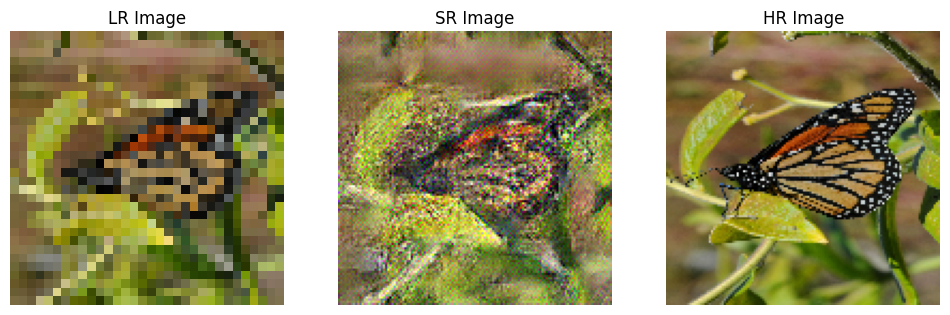

Content Loss for SR Image: 13.524605751037598


In [2]:
# Testing and Visualization

# Load the generator
generator.load_state_dict(torch.load("final_generator.pt"))  # Load the latest saved model
generator.eval()

# Move a test image to the device
ix = np.random.randint(0, len(lr_test), 1)
lr_image = lr_test[ix].to(device)
hr_image = hr_test[ix].to(device)

# Generate SR image
with torch.no_grad():
    sr_image = generator(lr_image)

# Calculate loss for the SR image
vgg_features_real = vgg(hr_image)
vgg_features_fake = vgg(sr_image)
content_loss = criterion_content(vgg_features_fake, vgg_features_real).item()  # Get the scalar value



# Move images back to CPU and convert to NumPy for display
lr_image = lr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
hr_image = hr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
sr_image = sr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()


# Display images and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("LR Image")
plt.imshow(lr_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR Image")
plt.imshow(sr_image)
plt.axis("off")


plt.subplot(1, 3, 3)
plt.title("HR Image")
plt.imshow(hr_image)
plt.axis("off")

plt.show()



print(f"Content Loss for SR Image: {content_loss}")